# CX 4230, Spring 2016 [12]: Markov chain analysis of the SIR-CA infection model

## (Sample solutions)

The goal of this notebook is to analyze theoretically the SIR-CA model of [Lab 11](http://nbviewer.jupyter.org/github/rvuduc/cx4230-ipynbs/blob/master/11--infection.ipynb). To complete it, you will need the SIR-CA machinery from Lab 9; we've packaged that up in a module that one of the code cells below will download.

Recall our motivation for a different kind of analysis, alluded to in the [slides for Lab 11](https://t-square.gatech.edu/access/content/group/gtc-59b8-dc03-5a67-a5f4-88b8e4d5b69a/cx4230-sp16--11-infection-and-diffusion.pdf): there is a combinatorial explosion in the number of possible states as the recovery time or problem size increase; if you just need some very high-level summary statistics, these simulations might be overkill.

## Setup

Run the following code cells to get started.

In [1]:
# Our usual multidimensional array tools
import numpy as np
import scipy as sp
import scipy.sparse

# Some handy combinatorial functions, e.g.,
# for generating permutations and combinations.
# See: https://docs.python.org/3/library/itertools.html
import itertools

In [2]:
 # Core plotting support
import matplotlib.pyplot as plt
%matplotlib inline

We packaged up the SIR-CA implementation from Lab 11 into a module. The following code cell will download and import some of the functions and constants of this module.

In [3]:
import os
os.makedirs ('cx4230', exist_ok=True)

# http://stackoverflow.com/questions/7243750/download-file-from-web-in-python-3
import urllib.request
MOD_URL = 'https://github.com/rvuduc/cx4230-ipynbs/raw/master/cx4230/sirca.py'
MOD_LOCAL = 'cx4230/sirca.py'
urllib.request.urlretrieve (MOD_URL, MOD_LOCAL)

%reload_ext autoreload
%autoreload 2

from cx4230 import sirca
from cx4230.sirca import \
    create_new_grid, set_recovery_time, infected, exposed, susceptible, \
    show_peeps, sim, isim

Run this cell to verify the module is working.

@ recovery time: 1
@ max steps: 50


<function cx4230.sirca.isim>

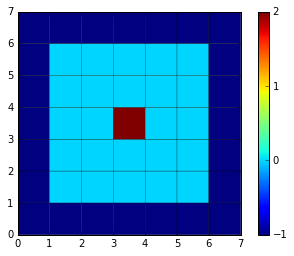

In [4]:
from ipywidgets import interact

interact (isim
          , m=(1, 10, 1)
          , n=(1, 10, 1)
          , max_steps=(0, 100, 1)
          , tau=(0.0, 1.0, 0.1)
          , dt=(0, 10, 1)
          , seed=(0, 100, 1)
         )

## Target system to analyze: a 1-D, 3-cell grid

Per the lecture notes, let's analyze the convergence of a 1-D system consisting of just 3 cells, where the conditional probability of infection for any exposed cell is $\tau=0.2$ and the recovery time is $k=2$ days.

In [69]:
M, N = 1, 3 # M x N grid
TAU = 0.4
K = 2

set_recovery_time (K)

5

## Defining the state space

To carry out the Markov chain analysis, recall that you need to do the following.

1. Define the state space, $S$.
2. Construct a probability transition matrix, $P \equiv \left(p_{ij}\right)$ where $p_{ij} \equiv \mathrm{Pr}[s_j\left|s_i\right.]$ is the conditional probability of moving to state $s_j$ starting from state $s_i$ for every pair of states $s_i, s_j \in S$.

For the 1-D, 3-cell system, the state space $S$ consists of all possible grid states, $s \equiv (g_1, g_2, g_3)$ where $g_i \in \left\{ \mathtt{S}, \mathtt{I}_1, \ldots, \mathtt{I}_k, \mathtt{R} \right\}$.

In [70]:
from cx4230.sirca import EMPTY, SUSCEPTIBLE, INFECTED, RECOVERED
CELL_VALUES = range (SUSCEPTIBLE, RECOVERED+1)
print ("Possible cell values:", list (CELL_VALUES))

Possible cell values: [0, 1, 2, 3]


**Exercise.** Generate a Python [set()](https://docs.python.org/3/library/stdtypes.html#set) named `S` that contains all possible grid-state triples.

> Hint: Take a look at [`itertools.product()`](https://docs.python.org/3/library/itertools.html#itertools.product).

In [71]:
# @YOUSE: Generate S
#S = set (...)
S = set (itertools.product (CELL_VALUES, repeat=M*N))

print ("--- k ==", K, "==>", len (S), "states ---\n", S)

--- k == 2 ==> 64 states ---
 {(3, 0, 2), (0, 1, 1), (1, 0, 3), (1, 3, 2), (3, 0, 3), (0, 1, 2), (1, 0, 0), (1, 3, 1), (0, 1, 3), (1, 0, 1), (3, 3, 1), (1, 3, 0), (2, 3, 0), (3, 3, 0), (0, 2, 1), (2, 3, 1), (3, 3, 3), (0, 2, 0), (2, 3, 2), (3, 3, 2), (0, 2, 3), (2, 3, 3), (0, 2, 2), (3, 2, 2), (2, 0, 1), (3, 1, 3), (3, 2, 3), (0, 3, 2), (1, 2, 0), (2, 0, 0), (0, 0, 3), (3, 1, 2), (3, 2, 0), (0, 3, 3), (1, 2, 1), (2, 0, 3), (0, 0, 2), (3, 1, 1), (3, 2, 1), (0, 3, 0), (1, 2, 2), (2, 0, 2), (0, 0, 1), (3, 1, 0), (0, 3, 1), (1, 2, 3), (0, 0, 0), (2, 1, 2), (1, 1, 1), (2, 2, 3), (2, 1, 3), (1, 1, 0), (2, 2, 2), (2, 1, 0), (0, 1, 0), (1, 1, 3), (2, 2, 1), (2, 1, 1), (1, 1, 2), (2, 2, 0), (3, 0, 0), (3, 0, 1), (1, 0, 2), (1, 3, 3)}


To construct the probability transition matrix, $P$, we will eventually need to map individual states to integer indices. The following code builds two lookup tables for converting grid states to integers and vice-versa.

In [72]:
IND_TO_S = dict (enumerate (S))
S_TO_IND = {val: key for (key, val) in IND_TO_S.items ()}

print ("==> Index to state table:\n", IND_TO_S, "\n")
print ("==> State to index table:\n", S_TO_IND)

==> Index to state table:
 {0: (3, 0, 2), 1: (0, 1, 1), 2: (1, 0, 3), 3: (1, 3, 2), 4: (3, 0, 3), 5: (0, 1, 2), 6: (1, 0, 0), 7: (1, 3, 1), 8: (0, 1, 3), 9: (1, 0, 1), 10: (3, 3, 1), 11: (1, 3, 0), 12: (2, 3, 0), 13: (3, 3, 0), 14: (0, 2, 1), 15: (2, 3, 1), 16: (3, 3, 3), 17: (0, 2, 0), 18: (2, 3, 2), 19: (3, 3, 2), 20: (0, 2, 3), 21: (2, 3, 3), 22: (0, 2, 2), 23: (3, 2, 2), 24: (2, 0, 1), 25: (3, 1, 3), 26: (3, 2, 3), 27: (0, 3, 2), 28: (1, 2, 0), 29: (2, 0, 0), 30: (0, 0, 3), 31: (3, 1, 2), 32: (3, 2, 0), 33: (0, 3, 3), 34: (1, 2, 1), 35: (2, 0, 3), 36: (0, 0, 2), 37: (3, 1, 1), 38: (3, 2, 1), 39: (0, 3, 0), 40: (1, 2, 2), 41: (2, 0, 2), 42: (0, 0, 1), 43: (3, 1, 0), 44: (0, 3, 1), 45: (1, 2, 3), 46: (0, 0, 0), 47: (2, 1, 2), 48: (1, 1, 1), 49: (2, 2, 3), 50: (2, 1, 3), 51: (1, 1, 0), 52: (2, 2, 2), 53: (2, 1, 0), 54: (0, 1, 0), 55: (1, 1, 3), 56: (2, 2, 1), 57: (2, 1, 1), 58: (1, 1, 2), 59: (2, 2, 0), 60: (3, 0, 0), 61: (3, 0, 1), 62: (1, 0, 2), 63: (1, 3, 3)} 

==> State to index t

The states are tuples whereas the grid in our simulation is a 2-D array (with an artificial empty boundary). Here are some handy functions to convert between a grid and a state.

In [73]:
def convert_state_to_grid (s, m, n):
    """
    Converts a state, given as a tuple `s`, into an equivalent
    `m` x `n` grid.
    """
    G = create_new_grid (m, n)
    G_interior = G[1:-1, 1:-1]
    G_interior[:, :] = np.array (list (s)).reshape ((m, n))
    return G

def convert_grid_to_state (G):
    """
    Converts a an `m` x `n` grid `G` (+ its empty boundary)
    into a `m*n`-tuple.
    """
    G_interior = G[1:-1, 1:-1]
    return tuple (G_interior.reshape (np.prod (G_interior.shape)))

In [74]:
# Test
G0 = create_new_grid (M, N)
G0[int ((M+2)/2), int ((N+2)/2)] = INFECTED

print ("==> Original grid:")
print (G0, "\n")

print ("==> Equivalent state (id):")
s0 = convert_grid_to_state (G0)
i0 = S_TO_IND[s0]
print ("State", s0, "--> index", i0, "\n")

print ("==> Convert back to grid:")
s0_prime = IND_TO_S[i0]
G0_prime = convert_state_to_grid (s0_prime, M, N)
print (G0_prime, "\n")

assert (G0 == G0_prime).all ()
print ("==> Passed!")

==> Original grid:
[[-1 -1 -1 -1 -1]
 [-1  0  1  0 -1]
 [-1 -1 -1 -1 -1]] 

==> Equivalent state (id):
State (0, 1, 0) --> index 54 

==> Convert back to grid:
[[-1 -1 -1 -1 -1]
 [-1  0  1  0 -1]
 [-1 -1 -1 -1 -1]] 

==> Passed!


## Reachability

The last thing you need to compute $p_{ij}$ is a way to enumerate all _reachable_ $j$ values, given $i$. The following code cells build a function to determine reachability.

First, here is an auxiliary function to get a list of tuples that are the locations of any non-zero value of a given grid.

In [75]:
def find_nonzero_locs (G):
    """
    Given a grid G, returns a list of all locations (i, j)
    where G[i, j] is not equal to zero.
    """
    (I, J) = np.nonzero (G)
    return list (zip (I, J))

# Test
print (find_nonzero_locs (exposed (G0)))

[(1, 1), (1, 3)]


**Exercise.** Let $\tau$ be the conditional probability that an exposed individual becomes infected. Further suppose the grid contains $n_e$ exposed individuals.

1. How many different ways are there for $n_s$ individuals to become infected? (Assume $0 \leq n_s \leq n_e$.)
2. What is the probability that $n_s$ of the $n_e$ individuals will become infected?

> @YOUSE: _Answer_:
> 
> 1. $n_e \choose n_s$, since that is the number of ways to choose $n_s$ elements from $n_e$ possibilities.
> 2. The probability of any given choice of $n_s$ elements from among a set of $n_e$ options is $\tau^{n_s} (1-\tau)^{n_e-n_s}$. Since there are ${n_e \choose n_s}$ such choices, then the total probability of $n_s$ individuals being infected given $n_e$ exposed individuals is ${n_e \choose n_s} \tau^{n_s} (1-\tau)^{n_e-n_s}$.

In [76]:
def reachable (G, tau):
    # Find all infected cells
    I = infected (G)
    if np.sum (I) == 0: # No infected cells
        yield (1.0, G)
    else: # >= 1 infected cell
        # Find number and locations of all exposed cells
        locs_E = find_nonzero_locs (exposed (G) * susceptible (G))
        n_E = len (locs_E)

        # Try all possible spreading combinations
        for k in range (0, n_E+1):
            # Probability that a particular set of k exposed people become infected:
            prob_k = (tau**k) * ((1.0 - tau)**(n_E - k))

            # Enumerate all reachable infection states
            for spread_locs_k in itertools.combinations (locs_E, k):
                G_next = np.copy (G) + I
                for (i, j) in spread_locs_k:
                    G_next[i, j] = INFECTED
                yield (prob_k, G_next)

In [77]:
n_states = len (S)
nz_i = []
nz_j = []
nz_val = []
for s_i in S:
    i = S_TO_IND[s_i]
    G_i = convert_state_to_grid (s_i, M, N)
    
    for (p_ij, G_j) in reachable (G_i, TAU):
        s_j = convert_grid_to_state (G_j)
        j = S_TO_IND[s_j]
        nz_i.append (i)
        nz_j.append (j)
        nz_val.append (p_ij)
            
P = sp.sparse.coo_matrix ((nz_val, (nz_i, nz_j)), (n_states, n_states))
print ("no. of states ==", n_states)
print ("tau ==", TAU, "; P = (p_{ij}) =\n", P)
print ("nnz(P) ==", P.nnz)
print ("row sums ==", P.sum (axis=1))

no. of states == 64
tau == 0.4 ; P = (p_{ij}) =
   (0, 4)	0.6
  (0, 25)	0.4
  (1, 22)	0.6
  (1, 40)	0.4
  (2, 35)	0.6
  (2, 50)	0.4
  (3, 21)	1.0
  (4, 4)	1.0
  (5, 20)	0.6
  (5, 45)	0.4
  (6, 29)	0.6
  (6, 53)	0.4
  (7, 18)	1.0
  (8, 20)	0.6
  (8, 45)	0.4
  (9, 41)	0.6
  (9, 47)	0.4
  (10, 19)	1.0
  (11, 12)	1.0
  (12, 13)	1.0
  (13, 13)	1.0
  (14, 27)	0.6
  (14, 3)	0.4
  (15, 19)	1.0
  (16, 16)	1.0
  :	:
  (47, 26)	1.0
  (48, 52)	1.0
  (49, 16)	1.0
  (50, 26)	1.0
  (51, 59)	0.6
  (51, 56)	0.4
  (52, 16)	1.0
  (53, 32)	0.6
  (53, 38)	0.4
  (54, 17)	0.36
  (54, 28)	0.24
  (54, 14)	0.24
  (54, 34)	0.16
  (55, 49)	1.0
  (56, 19)	1.0
  (57, 23)	1.0
  (58, 49)	1.0
  (59, 13)	0.6
  (59, 10)	0.4
  (60, 60)	1.0
  (61, 0)	0.6
  (61, 31)	0.4
  (62, 35)	0.6
  (62, 50)	0.4
  (63, 21)	1.0
nnz(P) == 94
row sums == [[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.

In [78]:
# Index case:
x0 = np.zeros ((n_states, 1))
x0[S_TO_IND[(0, 1, 0)]] = 1.0

# Compute the steady-state distribution
x = x0
for t in range (2*K):
    x = P.transpose ().dot (x)

# Summarize the "interesting" states
x_sorted = sorted (list (enumerate (x)), key=lambda t: t[1], reverse=True)
x_interesting = list (filter (lambda t: t[1] > 0.0, x_sorted))

print ("=== Parameter summary ===")
print ("M * N: %d x %d == %d" % (M, N, M*N))
print ("TAU: %g" % TAU)
print ("K: %d" % K)

print ("\n=== Results ===\n")

print ("%d state(s) have a non-zero steady-state probability:" % len (x_interesting))
for (i, x_i) in x_interesting:
    print ("  %d:" % i, "Pr[%s] ==" % str(IND_TO_S[i]), x_i[0])

nnz_hist = np.zeros (M*N+1)
for (i, x_i) in x_interesting:
    nnz = sum ([j > 0 for j in IND_TO_S[i]])
    nnz_hist[nnz] += x_i[0]
    
print ("\nProbability of k persons being infected:")
E_k = 0.0
for (k, p_k) in enumerate (nnz_hist):
    print ("  Pr[%d infected] == %g" % (k, p_k))
    E_k += k * p_k
print ("  ==> Expected value of k ==", E_k)
print ("  ==> Expected fraction infected ==", E_k/(M*N))

=== Parameter summary ===
M * N: 1 x 3 == 3
TAU: 0.4
K: 2

=== Results ===

4 state(s) have a non-zero steady-state probability:
  16: Pr[(3, 3, 3)] == 0.4096
  13: Pr[(3, 3, 0)] == 0.2304
  33: Pr[(0, 3, 3)] == 0.2304
  39: Pr[(0, 3, 0)] == 0.1296

Probability of k persons being infected:
  Pr[0 infected] == 0
  Pr[1 infected] == 0.1296
  Pr[2 infected] == 0.4608
  Pr[3 infected] == 0.4096
  ==> Expected value of k == 2.28
  ==> Expected fraction infected == 0.76
